###Import liberties

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

####Read and display the data

In [62]:
data = pd.read_csv('BTC-USD.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3368,2023-12-07,43769.132813,44042.589844,42880.648438,43292.664063,43292.664063,27635760671
3369,2023-12-08,43293.136719,44705.515625,43125.296875,44166.601563,44166.601563,24421116687
3370,2023-12-09,44180.019531,44361.257813,43627.597656,43725.984375,43725.984375,17368210171
3371,2023-12-10,43728.382813,44034.625000,43593.285156,43779.699219,43779.699219,13000481418


####Omit all the columns excludes Date and Close

In [63]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3368,2023-12-07,43292.664063
3369,2023-12-08,44166.601563
3370,2023-12-09,43725.984375
3371,2023-12-10,43779.699219


####Devivce seting

In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Plot the Graph

<ipython-input-65-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


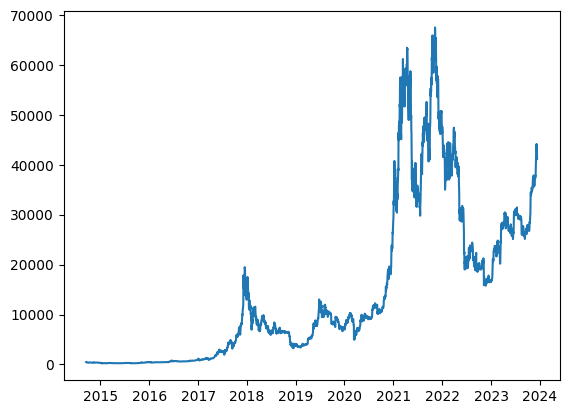

In [65]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

#### Prepare df for LSTM by shiffting data t - n steps

In [66]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014
...,...,...,...,...,...,...,...,...
2023-12-07,43292.664063,43746.445313,44080.648438,41980.097656,39978.390625,39476.332031,38688.750000,37712.746094
2023-12-08,44166.601563,43292.664063,43746.445313,44080.648438,41980.097656,39978.390625,39476.332031,38688.750000
2023-12-09,43725.984375,44166.601563,43292.664063,43746.445313,44080.648438,41980.097656,39978.390625,39476.332031


#### Convert data to numpy array

In [67]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[  423.204987,   435.790985,   402.152008, ...,   394.79599 ,
          424.440002,   457.334015],
       [  411.574005,   423.204987,   435.790985, ...,   408.903992,
          394.79599 ,   424.440002],
       [  404.424988,   411.574005,   423.204987, ...,   398.821014,
          408.903992,   394.79599 ],
       ...,
       [43725.984375, 44166.601563, 43292.664063, ..., 41980.097656,
        39978.390625, 39476.332031],
       [43779.699219, 43725.984375, 44166.601563, ..., 44080.648438,
        41980.097656, 39978.390625],
       [41176.277344, 43779.699219, 43725.984375, ..., 43746.445313,
        44080.648438, 41980.097656]])

In [68]:
shifted_df_as_np.shape

(3366, 8)

#### Data normalization

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99272573, -0.99235219, -0.99335055, ..., -0.99356887,
        -0.99268907, -0.99171283],
       [-0.99307092, -0.99272573, -0.99235219, ..., -0.99315016,
        -0.99356887, -0.99268907],
       [-0.99328309, -0.99307092, -0.99272573, ..., -0.99344941,
        -0.99315016, -0.99356887],
       ...,
       [ 0.2924382 ,  0.30551508,  0.27957788, ...,  0.24062281,
         0.18121503,  0.16631466],
       [ 0.29403238,  0.2924382 ,  0.30551508, ...,  0.30296412,
         0.24062281,  0.18121503],
       [ 0.21676658,  0.29403238,  0.2924382 , ...,  0.29304545,
         0.30296412,  0.24062281]])

#### Prepare traget and features

In [70]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3366, 7), (3366,))

In [71]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99171283, -0.99268907, -0.99356887, ..., -0.99344941,
        -0.99335055, -0.99235219],
       [-0.99268907, -0.99356887, -0.99315016, ..., -0.99335055,
        -0.99235219, -0.99272573],
       [-0.99356887, -0.99315016, -0.99344941, ..., -0.99235219,
        -0.99272573, -0.99307092],
       ...,
       [ 0.16631466,  0.18121503,  0.24062281, ...,  0.29304545,
         0.27957788,  0.30551508],
       [ 0.18121503,  0.24062281,  0.30296412, ...,  0.27957788,
         0.30551508,  0.2924382 ],
       [ 0.24062281,  0.30296412,  0.29304545, ...,  0.30551508,
         0.2924382 ,  0.29403238]])

#### Split index and create train and test sets

In [72]:
split_index = int(len(X) * 0.95)

split_index

3197

In [73]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3197, 7), (169, 7), (3197,), (169,))

####Reshape and convert to tensors

In [74]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3197, 7, 1), (169, 7, 1), (3197, 1), (169, 1))

In [75]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3197, 7, 1]),
 torch.Size([169, 7, 1]),
 torch.Size([3197, 1]),
 torch.Size([169, 1]))

#### Create TimeSeriesDataset

In [76]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [77]:
train_dataset

#### Data Loaders

In [78]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


#### Define the LSTM model

In [80]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Definite the backprop process

In [81]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [82]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

####Define Hyperparameters and train

In [83]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.484
Batch 200, Loss: 0.171

Val Loss: 0.150
***************************************************

Epoch: 2
Batch 100, Loss: 0.086
Batch 200, Loss: 0.042

Val Loss: 0.019
***************************************************

Epoch: 3
Batch 100, Loss: 0.018
Batch 200, Loss: 0.011

Val Loss: 0.007
***************************************************

Epoch: 4
Batch 100, Loss: 0.009
Batch 200, Loss: 0.008

Val Loss: 0.010
***************************************************

Epoch: 5
Batch 100, Loss: 0.007
Batch 200, Loss: 0.007

Val Loss: 0.008
***************************************************

Epoch: 6
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005

Val Loss: 0.005
***************************************************

Epoch: 7
Batch 100, Loss: 0.005
Batch 200, Loss: 0.004

Val Loss: 0.004
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.004
***************************************************



#### Plot the training results

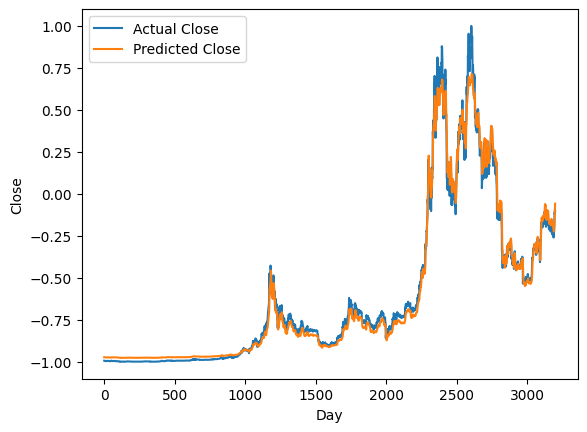

In [84]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


####Return train values to the original numbers

In [85]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 1119.31780276,  1120.74372453,  1119.78373776, ...,
       30693.73725269, 31538.30970887, 31922.44098183])

In [86]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  423.20488971,   411.57458981,   404.42489759, ...,
       30695.46869325, 30548.69540303, 30480.26170218])

####plot training results [now with the original values]

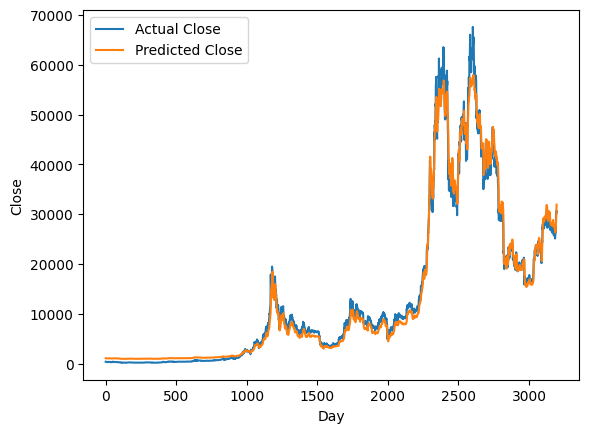

In [87]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


####Return test values to the original numbers

In [88]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([32010.80495183, 31889.72712324, 31968.61624479, 31779.88595981,
       31788.98072982, 31840.22755465, 31933.04853433, 32011.5113856 ,
       32297.84099442, 32333.35648803, 32192.40914259, 31798.59214542,
       31708.73447217, 31671.80711518, 31620.91727287, 31715.25003087,
       31883.40085063, 31894.09827636, 32362.46587749, 32194.48978336,
       31991.5324142 , 31812.38793848, 31659.27004954, 31446.80620056,
       31338.97588807, 31252.86828864, 31247.17363912, 31200.20960043,
       31313.82142316, 30992.88057606, 30757.29420069, 30670.75179553,
       30579.45263588, 30587.57536908, 30628.40794419, 30631.9827903 ,
       30595.87684458, 30771.32848418, 30672.40767229, 30587.95193292,
       30481.58268815, 30398.52525587, 30351.37193109, 30394.93685346,
       30712.68092456, 30851.70930065, 30859.56090788, 30817.14776878,
       30780.32685384, 30693.78846537, 30693.81356963, 30606.74096258,
       30327.28088248, 29195.63899505, 28087.80623542, 27403.09165894,
      

In [89]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([30271.13094533, 30688.16410777, 30086.24613035, 30445.3514722 ,
       30477.25195288, 30590.0780124 , 30620.76947209, 31156.43957627,
       30777.58195445, 30514.16600461, 29909.33794179, 30342.26561312,
       30292.5411104 , 30171.23433099, 30414.47072641, 30620.95122691,
       30391.64643858, 31476.04889362, 30334.06832028, 30295.80667207,
       30249.13283858, 30145.88857165, 29856.56251878, 29913.92373631,
       29792.01570996, 29908.74422613, 29771.80276688, 30084.53904091,
       29176.91624063, 29227.39085854, 29354.97269787, 29210.68949884,
       29319.24632851, 29356.91777566, 29275.30835689, 29230.11115576,
       29675.73254329, 29151.95909518, 29178.6795636 , 29074.09171686,
       29042.12696928, 29041.85534123, 29180.57794747, 29765.49230995,
       29561.49436936, 29429.59158541, 29397.71470273, 29415.96499504,
       29282.9139424 , 29408.44325774, 29170.3474609 , 28701.77952781,
       26664.55054424, 26049.55651279, 26096.20524203, 26189.58403828,
      

####Plot test results

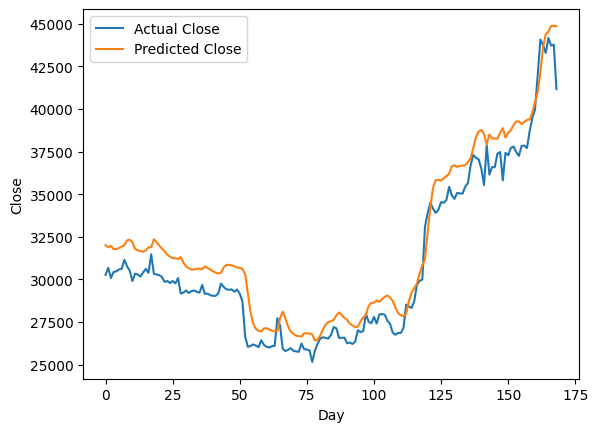

In [90]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
